# Microsoft ML Retail Churn Tutorial

1. [Overview](#Overview)
2. [Fitting Models that Predict Retail Churn](#RetailChurn)
3. [What's Next?](#Next)

## <a id="Overview">1. OVERVIEW</a>

Microsoft Machine Learning, or Microsoft ML for short, is an R package within Microsoft R Services that includes powerful machine learning algorithms and associated tools. The tutorial is an introduction to Microsoft ML for data scientists who want to take advantage of its unique capabilities.  It is intended primarily for those who are comfortable with using Microsoft R Services for data science, and want to see an end-to-end example that uses Microsoft ML to carry out common data science tasks.

## <a id="RetailChurn">2. FITTING MODELS THAT PREDICT RETAIL CHURN</a>

The tutorial steps through the fitting of a model for rxPredicting retail churn. Customer churn is an expensive problem in retail, where a fraction of the current customers, the churners, stop patronizing a business, leading to a loss of business. We will focus on rxPredicting which customers are likely to churn, and we will leave identifying how to keep customers from churning to other tutorials.

The tutorial begins from data imported from a retail database, goes through the creation of a label identifying customers who have churned and the creation of features based on customer purchase history, fits a model using multiple learning algorithms, and compares the performance of these fit models to select the best one. The initial and final steps in this process will be familiar to Microsoft R Services users, while the model fitting and performance evaluation steps will involve new Microsoft ML commands.

### <a id="Packages">2.1. LOADING THE PACKAGES</a>

The tutorial is broken into steps, the first being loading the Microsoft ML package. When you execute the first step, there should be no output.

In [1]:
#-----------------------------------------------------------------------
# 1. Load packages.
#-----------------------------------------------------------------------
if (!suppressPackageStartupMessages(require("MicrosoftML",
                                            quietly = TRUE,
                                            warn.conflicts = FALSE))) {
    stop("The MicrosoftML package does not seem to be installed, so this\n",
         "script cannot be run. If Microsoft R Server with MML is installed,\n",
         "you may need to switch the R engine option. In R Tools for Visual\n",
         "Studio, this option is under:\n",
         "\tR Tools -> Options -> R Engine.\n",
         "If Microsoft R Server with MML is not installed, you can download it\n",
         "from https://microsoft.sharepoint.com/teams/TLC/SitePages/MicrosoftML.aspx\n")
}

### <a id="Import">2.2. IMPORT DATA</a>

The second step consists of importing the data we will use to fit a model. In our case, there are two tables of data: the customer table, indexed by a UserId, and the customer activity table, indexed by a TransactionId. This section imports the dataCustomers and dataActivity tables into Xdfs. These Xdfs are an efficient way of working with large amounts of data. They are files in which the rows are grouped in blocks whose size is specified by the parameter rowsPerBlock.

In [2]:
#-----------------------------------------------------------------------
# 2. Import data.
#-----------------------------------------------------------------------

# The directory containing data files.
dataDir <- file.path("Data")

# Verify that the data files exists.
if (!all(file.exists(file.path(dataDir,
                               c("Retail Churn Users.csv",
                                 "Retail Churn Activity.csv"))))) {
          #12345678901234567890123456789012345678901234567890123456789012345678901
    stop("The data files needed for running this script cannot be found.\n",
         "You may need to set R's working directory to the location of the Data\n",
         "directory.\n")
}

# The data chunk size.
rowsPerBlock <- 1000000

The RetailUsers table has one row per customer, and five columns: UserId, Age, Address, Gender, and UserType. Because the Gender and UserType columns have the same value for all users, they are ignored. The remaining three columns are factors.

In [3]:
# The customer characteristics data. Drop the constant-valued Gender
# and UserType columns.
dataCustomersSource <-
    RxTextData(file.path(dataDir, "Retail Churn Users.csv"),
               varsToDrop = c("Gender", "UserType"),
               colInfo = list(UserId = list(type = "factor"),
                              Age = list(type = "factor"),
                              Address = list(type = "factor")))

# Import the customer characteristics.
dataCustomers <-
    rxImport(dataCustomersSource,
             outFile = tempfile(fileext = ".xdf"),
             rowsPerRead = rowsPerBlock)

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.049 seconds 


You can explore these newly loaded data by using commands. For example, you can view the first few rows of the customer table as follows:

In [4]:
head(dataCustomers)

UserId,Age,Address
2105345,D,F
2085920,F,F
1976717,C,C
768535,A,E
1895117,D,F
1587807,J,E


The RetailActivity table has one row per transaction, and nine columns: Column 0, TransactionId, Timestamp, UserId, ItemId, Quantity, Value, Location, and ProductCategory. Because Column 0 is the row number, it is ignored, and because Location and ProductCategory each have the same value for all users, they are ignored. Of the remaining six columns, three are factors: TransactionId, UserId, and ItemId, Timestamp is a date, and Quality and Value are numbers.

Note:
* Because Timestamp is a date, it is first read in as a character variable, and then a transform is applied to convert it to a date.
* A key aspect of the import process consists in using the list of UserIds from the dataCustomers table to import the dataActivity table; this allows later table merges to be successful without additional work.

In [5]:
# The levels for UserId. This is used when importing customer activity.
UserId.levels <-
    rxGetVarInfo(dataCustomers, varsToKeep = "UserId")$UserId$levels

# The customer activity. Drop the row count Column 0 column and the
# constant-valued Location and ProductCategory columns.
dataActivitySource <-
    RxTextData(file.path(dataDir, "Retail Churn Activity.csv"),
               varsToDrop = c("Column 0", "Location", "ProductCategory"),
               colInfo = list(TransactionId = list(type = "factor"),
                              Timestamp = list(type = "character"),
                              UserId = list(type = "factor",
                                            levels = UserId.levels),
                              ItemId = list(type = "factor")))

# Import the customer activity.
dataActivity <-
    rxImport(dataActivitySource,
             transforms = list(Timestamp = as.POSIXct(Timestamp,
                                                      format = "%m/%d/%Y")),
             outFile = tempfile(fileext = ".xdf"),
             rowsPerRead = rowsPerBlock)

Rows Read: 252204, Total Rows Processed: 252204, Total Chunk Time: 5.595 seconds 


We can see from the output that the activity table has 252,204 rows, and its first few rows are

In [6]:
head(dataActivity)

TransactionId,Timestamp,UserId,ItemId,Quantity,Value
817747,2000-11-01,1704129,4710730000000,1,46
818083,2000-11-01,1704129,4710080000000,1,59
818107,2000-11-01,1704129,4711300000000,1,35
818153,2000-11-01,1704129,4714980000000,2,48
828300,2000-11-03,1704129,4710060000000,1,110
829091,2000-11-03,1704129,4710580000000,2,26


### <a id="Label">2.3. CREATE THE LABEL</a>

For a customer, the label shows whether or not they are expected to churn. We define a churner as a customer who will have fewer than churnThrehold transactions in the next 21 days, the churn period. Since the label is a rxPrediction of the future, we can only use data known prior to the churn period to make the rxPrediction. Then we must first split dataActivity table into two parts: the data from the 21 days of the churn period, and the data from before the start of the churn period.

We begin by getting the range of dates for which we have transaction data. The commands in the next cell get the smallest and largest dates in the dataTransactions table. Although these are dates, rxSummary returns them as date numbers that are then converted back into dates. The last command verifies that we have transactions that cover at least twice as many days as the duration of the churn period.

In [7]:
#-----------------------------------------------------------------------
# 3. Create the label.
#-----------------------------------------------------------------------
# The churn period is the next churnPeriod days. A customer has churned
# if their activity drops below churnThreshold in the churn period. Then
# the rxPrediction of churn is made using statistics about customer
# activity from before the churn period.
churnPeriod <- as.difftime(21, units = "days")
churnThreshold <- 0

# The date range of the activity data.
activityRange <-
    rxSummary( ~ Timestamp, dataActivity,
              summaryStats = c("Max", "Min"))$sDataFrame
activityMin <- as.POSIXct(activityRange$Min, origin = "1970-01-01")
activityMax <- as.POSIXct(activityRange$Max, origin = "1970-01-01")

# Verify that enough data are available.
if (activityMax - activityMin < 2 * churnPeriod) {
    stop("The training data period should be at least two times longer than the\n",
         "churn period.")
}

Rows Read: 252204, Total Rows Processed: 252204, Total Chunk Time: 0.068 seconds 
Computation time: 0.176 seconds.


You can see the range of dates as follows:

In [8]:
c(activityMin, activityMax)

[1] "2000-11-01 EST" "2001-02-28 EST"

Next, we compute the start date of the churn period, and use it to split off from dataActivity the transactions that happened before that date.

We use the rxDataStep function to pull the prechurn period activity from the dataActivity data set into a new data set. Its transformObjects input stores the churnPeriodStart variable in a list for use by rxDataStep when it evaluates the expression in the rowSelection input.

In [9]:
# The start of the churn period.
churnPeriodStart <- activityMax - churnPeriod

# The activity data from the before the churn period.
prechurnActivity <-
    rxDataStep(dataActivity,
               rowSelection = Timestamp <= churnPeriodStart,
               transformObjects = list(churnPeriodStart = churnPeriodStart),
               outFile = tempfile(fileext = ".xdf"))

Rows Read: 252204, Total Rows Processed: 252204, Total Chunk Time: 1.148 seconds 


We see that the new prechurnActivity table has 46,686 fewer rows than the original dataActivity table:

In [10]:
nrow(dataActivity) - nrow(prechurnActivity)

[1] 46686

Now, we compute the total number of transactions for each customer and the number of transactions each customer had in prechurn period. The difference between these two quantities will be the number of transactions in the churn period for each customer.

We use the rxCube function to compute tables of counts of each UserId in first the dataActivity table, and then in the prechurnActivity table. We then merge those two tables by UserId so the quantities are side-by-side in one table.

In [11]:
# The total activity per customer is the number of rows per UserId
# in the complete data activity.
totalActivityCounts <-
    rxCube( ~ UserId, dataActivity,
           outFile = tempfile(fileext = ".xdf"),
           rowsPerBlock = rowsPerBlock)

# The prechurn period activity per customer is the number of rows per
# UserId in the prechurn activity.
prechurnActivityCounts <-
    rxCube( ~ UserId, prechurnActivity,
           outFile = tempfile(fileext = ".xdf"),
           rowsPerBlock = rowsPerBlock)

# Merge these data to line the numbers up.
activityCounts <-
    rxMerge(totalActivityCounts, prechurnActivityCounts,
            matchVars = "UserId",
            newVarNames1 = c(Counts = "totalCounts"),
            newVarNames2 = c(Counts = "prechurnCounts"),
            outFile = tempfile(fileext = ".xdf"),
            rowsPerOutputBlock = rowsPerBlock)

Rows Read: 252204, Total Rows Processed: 252204, Total Chunk Time: 0.087 seconds 
Computation time: 0.198 seconds.
Rows Read: 205518, Total Rows Processed: 205518, Total Chunk Time: 0.081 seconds 
Computation time: 0.185 seconds.
Number of rows written to file: 10000, Variable(s): UserId, Counts, Total number of rows in file: 10000
Time to sort data file: 0.130 seconds
Number of rows written to file: 10000, Variable(s): UserId, Counts, Total number of rows in file: 10000
Time to sort data file: 0.127 seconds
Time to merge data file: 0.177 seconds


We can see from the output from the last command that the number of rows in activityCounts is 10,000, which is the number of customers. And if we look at the top six rows of the activityCounts table, we see differences between customer's total activity and their activity in the prechurn period.

In [12]:
head(activityCounts)

UserId,totalCounts,prechurnCounts
2105345,8,8
2085920,4,1
1976717,39,39
768535,14,11
1895117,35,35
1587807,30,20


Finally, we compute the label by checking that the difference between the total and prechurn transactions is at most the churnThreshold.

In this case, the rxDataStep command lets us insert the Label variable into the dataset; here, the transformObjects input stores the churnThreshold variable in a list for use by rxDataStep when it evaluates the expression in the transforms input.

In [13]:
# Compute whether a customer is a churner.  A customer has churned if their
# activity drops below churnThreshold in the churn period.
dataLabel <-
    rxDataStep(activityCounts,
               transforms = list(Label =
                                    totalCounts - prechurnCounts <=
                                        churnThreshold),
               transformObjects = list(churnThreshold = churnThreshold),
               outFile = tempfile(fileext = ".xdf"))

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.038 seconds 


We can look the the labels assigned to the first six customers in the dataLabel table to see that they match our expectations:

In [14]:
head(dataLabel)

UserId,totalCounts,prechurnCounts,Label
2105345,8,8,TRUE
2085920,4,1,FALSE
1976717,39,39,TRUE
768535,14,11,FALSE
1895117,35,35,TRUE
1587807,30,20,FALSE


We can also get a numerical summary of the Label variable:

In [15]:
rxSummary(~ Label, dataLabel)

Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.003 seconds 
Computation time: 0.007 seconds.


Call:
rxSummary(formula = ~Label, data = dataLabel)

Summary Statistics Results for: ~Label
Data: dataLabel (RxXdfData Data Source)
File name:
    C:\Users\mabou\AppData\Local\Temp\RtmpKqkYjG\file82c267e2211.xdf
Number of valid observations: 10000 
 
 Name  Mean   StdDev    Min Max ValidObs MissingObs
 Label 0.5508 0.4974375 0   1   10000    0         

Because "Label" is a logical value, its mean is the proportion of rows where "Label" is TRUE, so 55.08% of the customers have been identified as churners. This shows the data are reasonably balanced between the churners and non-churners. Note that we could have asked for a summary of all columns in the dataLabel table with the shorter command:

In [16]:
# rxSummary(~ ., dataLabel) Do not run this command.

but the result would have needlessly taken tens of pages because one of the columns is the "UserId", a factor that is unique for each of the 10,000 rows.

### <a id="Features">2.4. CREATE THE FEATURES</a>

We use the prechurnActivity table to compute the activity-based features that will be used to rxPredict churning. There are three kinds of data: dates, numbers, and factors, each of which produces its own kind of features for each customer.

The dates are used to compute the mean number of days between a customer's transactions, and the number of days from the last of the customer's transactions to the start of the churn period. Because the computation of the number of days between transactions cannot be done in a simple way using Xdfs, we first pull the dates into a data frame, do the computation, and import the results in an Xdf.

In [ ]:
#-----------------------------------------------------------------------
# 4. Create the features.
#-----------------------------------------------------------------------
# Create features from the activity variables Timestamp, Quantity,
# Value, TransactionId, and ItemId. NOTE: The TransactionId feature will
# be obtained from the prechurnActivityCounts table.
#-----------------------------------------------------------------------
# Timestamp features are the per-customer recency and mean days between
# transactions. Recency is the number of days between the first day of
# the churn period and the last transaction.
TimestampDf <-
    rxDataStep(prechurnActivity, varsToKeep = c("UserId", "Timestamp"),
               maxRowsByCols = 2 * nrow(prechurnActivity))

TimestampFeaturesDf <-
    do.call(rbind,
            lapply(split(TimestampDf,
                         TimestampDf$UserId, drop = TRUE),
                   function(x) {
                       data.frame(UserId = x$UserId[1],
                                  Recency = churnPeriodStart -
                                               max(x$Timestamp),
                                  MeanDaysBetweenActivity =
                                   if (nrow(x) == 1) {
                                       0
                                   } else {
                                       mean(as.difftime(diff(sort(x$Timestamp)),
                                                        units = "days"))
                                   })
                   }))

TimestampFeatures <-
    rxImport(TimestampFeaturesDf,
             outFile = tempfile(fileext = ".xdf"),
             rowsPerRead = rowsPerBlock)

Rows Read: 205518, Total Rows Processed: 205518, Total Chunk Time: 0.085 seconds 


We can see from the output from the last command that there are 9,159 rows in the new table of time-based features, which is below the 10,000 rows of the dataLabel column. We can get a summary of the values in the table:

In [18]:
rxSummary(~ Recency + MeanDaysBetweenActivity, TimestampFeatures)

Rows Read: 9159, Total Rows Processed: 9159, Total Chunk Time: 0.008 seconds 
Computation time: 0.016 seconds.


Call:
rxSummary(formula = ~Recency + MeanDaysBetweenActivity, data = TimestampFeatures)

Summary Statistics Results for: ~Recency + MeanDaysBetweenActivity
Data: TimestampFeatures (RxXdfData Data Source)
File name:
    C:\Users\mabou\AppData\Local\Temp\RtmpARo8MX\file415c12c14a61.xdf
Number of valid observations: 9159 
 
 Name                    Mean         StdDev       Min Max     ValidObs
 Recency                     32.47887     27.96735 0        97 9159    
 MeanDaysBetweenActivity 161052.14456 279623.38217 0   3153600 9159    
 MissingObs
 0         
 0         

We can also plot MeanDaysBetweenActivity against Recency:

Rows Read: 9159, Total Rows Processed: 9159, Total Chunk Time: 0.014 seconds 


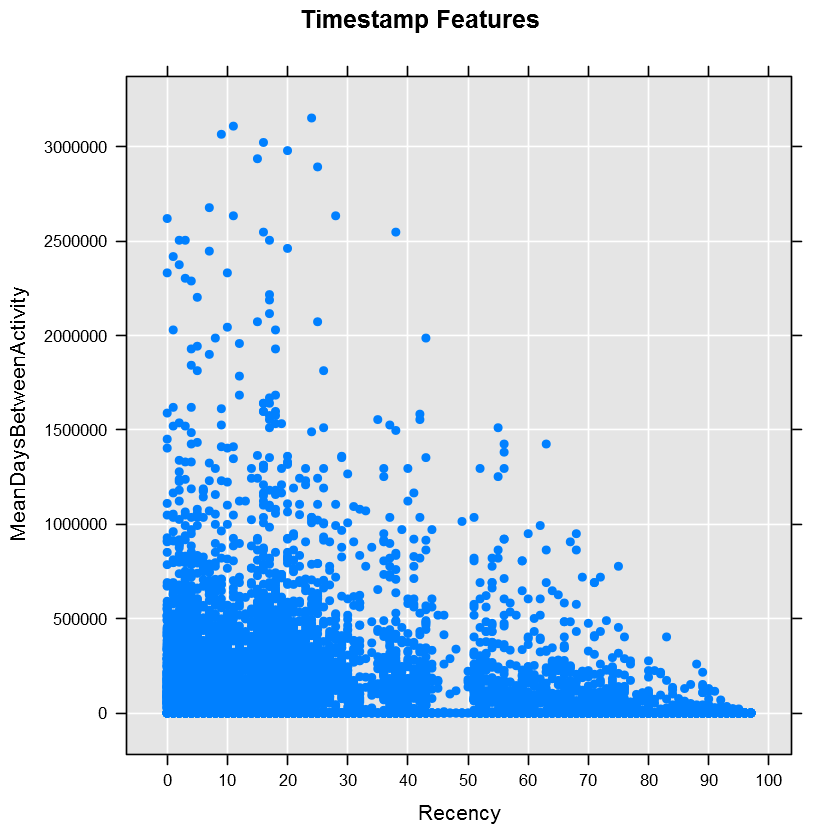

In [19]:
rxLinePlot(MeanDaysBetweenActivity ~ Recency, TimestampFeatures, type = "p", title = "Timestamp Features")

The results shown in the figure let us see that as Recency increases, the range of MeanDaysBetweenActivity decreases, which is reasonable.

We now derive features from the numerical data. These are Quantity and Value, and we use them to compute totals and standard deviations. Because the standard deviation will be undefined for customers with only one transaction, we will then replace the missing values in the data with zeros.

We first create the Quantity-based features:

In [20]:
# Quantity features are the per-customer total and standard deviation.
QuantityFeatures <-
    rxSummary(Quantity ~ UserId, prechurnActivity,
              summaryStats = c("Sum", "StdDev"),
              byGroupOutFile = tempfile(fileext = ".xdf"),
              rowsPerBlock = rowsPerBlock)$categorical[[1]]

# Replace missing standard deviations with 0s.
QuantityFeatures <-
    rxDataStep(QuantityFeatures,
               transforms = list(Quantity_StdDev =
                                    ifelse(is.na(Quantity_StdDev),
                                           0, Quantity_StdDev)),
               outFile = tempfile(fileext = ".xdf"))

Rows Read: 205518, Total Rows Processed: 205518, Total Chunk Time: 0.149 seconds 
Computation time: 0.378 seconds.
Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.080 seconds 


Then, we create the Value-based features:

In [21]:
# Value features are the per-customer total and standard deviation.
ValueFeatures <-
    rxSummary(Value ~ UserId, prechurnActivity,
              summaryStats = c("Sum", "StdDev"),
              byGroupOutFile = tempfile(fileext = ".xdf"),
              rowsPerBlock = rowsPerBlock)$categorical[[1]]

# Replace missing standard deviations with 0s.
ValueFeatures <-
    rxDataStep(ValueFeatures,
               transforms = list(Value_StdDev =
                                    ifelse(is.na(Value_StdDev),
                                           0, Value_StdDev)),
               outFile = tempfile(fileext = ".xdf"))

Rows Read: 205518, Total Rows Processed: 205518, Total Chunk Time: 0.116 seconds 
Computation time: 0.306 seconds.
Rows Read: 10000, Total Rows Processed: 10000, Total Chunk Time: 0.088 seconds 


We peek at the Quantity-based features:

In [22]:
head(QuantityFeatures)

,UserId,Quantity_StdDev,Quantity_Sum
1,2105345,0.353553390593274,9
2,2085920,0,5
3,1976717,1.96734474460618,72
4,768535,0.924416277737175,15
5,1895117,0.45281565433046,41
6,1587807,2.51521684740574,54


And we create features from the factor data TransactionId and ItemId. We use them to compute the number of unique transactions per customer, and the number of different items they purchased. Because the prechurnActivityCounts table already counts the number of unique transactions per customer, we won't need to compute that feature again. For the feature obtained from ItemId, we first get the unique the UserId and ItemId pairs, and then compute the number of ItemIds per UserId.

In [23]:
# TransactionId features are the per-customer number of unique
# transactions. These data are in the prechurnActivityCounts table that
# was previously created.
# ItemId features are the per-customer number of unique items.
# First get the unique ItemId-UserId pairs.
ItemIdUserIdPairs <-
    rxSort(prechurnActivity, sortByVars = c("UserId", "ItemId"),
           removeDupKeys = TRUE, varsToKeep = c("UserId", "ItemId"),
           outFile = tempfile(fileext = ".xdf"))

# Then count the number of rows per UserId.
ItemIdFeature <-
    rxCube( ~ UserId, ItemIdUserIdPairs,
           outFile = tempfile(fileext = ".xdf"),
           rowsPerBlock = rowsPerBlock)

Number of rows written to file: 144597, Variable(s): UserId, ItemId, Total number of rows in file: 144597
Time to sort data file: 0.765 seconds
Rows Read: 144597, Total Rows Processed: 144597, Total Chunk Time: 0.046 seconds 
Computation time: 0.069 seconds.


Next, we merge these three kinds of activity-based features into one table.

In [24]:
#-----------------------------------------------------------------------
# Merge the feature data by UserId
dataFeatures <-
    rxMerge(TimestampFeatures, QuantityFeatures, matchVars = "UserId",
            outFile = tempfile(fileext = ".xdf"),
            rowsPerOutputBlock = rowsPerBlock)

dataFeatures <-
    rxMerge(dataFeatures, ValueFeatures, matchVars = "UserId",
            outFile = tempfile(fileext = ".xdf"),
            rowsPerOutputBlock = rowsPerBlock)

dataFeatures <-
    rxMerge(dataFeatures, prechurnActivityCounts, matchVars = "UserId",
            newVarNames2 = c(Counts = "TransactionId_Counts"),
            outFile = tempfile(fileext = ".xdf"),
            rowsPerOutputBlock = rowsPerBlock)

dataFeatures <-
    rxMerge(dataFeatures, ItemIdFeature, matchVars = "UserId",
            newVarNames2 = c(Counts = "ItemId_Counts"),
            outFile = tempfile(fileext = ".xdf"),
            rowsPerOutputBlock = rowsPerBlock)

Number of rows written to file: 9159, Variable(s): UserId, Recency, MeanDaysBetweenActivity, Total number of rows in file: 9159
Time to sort data file: 0.203 seconds
Number of rows written to file: 10000, Variable(s): UserId, Quantity_StdDev, Quantity_Sum, Total number of rows in file: 10000
Time to sort data file: 0.158 seconds
Time to merge data file: 0.237 seconds
Number of rows written to file: 9159, Variable(s): UserId, Recency, MeanDaysBetweenActivity, Quantity_StdDev, Quantity_Sum, Total number of rows in file: 9159
Time to sort data file: 0.160 seconds
Number of rows written to file: 10000, Variable(s): UserId, Value_StdDev, Value_Sum, Total number of rows in file: 10000
Time to sort data file: 0.160 seconds
Time to merge data file: 0.258 seconds
Number of rows written to file: 9159, Number of columns: 7, Total number of rows in file: 9159
Time to sort data file: 0.169 seconds
Number of rows written to file: 10000, Variable(s): UserId, Counts, Total number of rows in file: 1000

As final features, we compute ratios of the sum features computed from Quantity and Value and the count features from TransactionId and ItemId.

In [25]:
# Compute feature ratios.
dataFeatures <-
    rxDataStep(dataFeatures,
               transforms =
                   list(Quantity_per_TransactionId =
                            Quantity_Sum / TransactionId_Counts,
                        Quantity_per_ItemId =
                            Quantity_Sum / ItemId_Counts,
                        Value_per_TransactionId =
                            Value_Sum / TransactionId_Counts,
                        Value_per_ItemId =
                            Value_Sum / ItemId_Counts),
               outFile = tempfile(fileext = ".xdf"),
               rowsPerRead = rowsPerBlock)

Rows Read: 9159, Total Rows Processed: 9159, Total Chunk Time: 0.094 seconds 


From the above output, we see that the data features table has 9,159 rows. We can now look at the values of these features for the first six customers. Note that the dataFeatures table has 13 column, so the output will likely overflow its window.

In [26]:
head(dataFeatures)

,UserId,Recency,MeanDaysBetweenActivity,Quantity_StdDev,Quantity_Sum,Value_StdDev,Value_Sum,TransactionId_Counts,ItemId_Counts,Quantity_per_TransactionId,Quantity_per_ItemId,Value_per_TransactionId,Value_per_ItemId
1,2105345,38,0,0.353553390593274,9,77.2212729757805,773,8,8,1.125,1.125,96.625,96.625
2,2085920,84,0,0,5,0,400,1,1,5,5,400,400
3,1976717,16,29557.8947368421,1.96734474460618,72,114.518784296792,4939,39,30,1.84615384615385,2.4,126.641025641026,164.633333333333
4,768535,24,475200,0.924416277737175,15,143.784118480703,1754,11,10,1.36363636363636,1.5,159.454545454545,175.4
5,1895117,2,129600,0.45281565433046,41,48.8186147166954,2222,35,28,1.17142857142857,1.46428571428571,63.4857142857143,79.3571428571429
6,1587807,15,163705.263157895,2.51521684740574,54,75.0587664503796,2123,20,18,2.7,3,106.15,117.944444444444


### <a id="Assemble">2.5. ASSEMBLE THE DATASET</a>

We merge the dataCustomers, dataLabel, and dataFeatures tables by UserId to create the dataset that we will use for training and testing.

In [27]:
#-----------------------------------------------------------------------
# 5. Assemble the dataset.
#-----------------------------------------------------------------------
# Merge the customer data, features, and label to form the dataset.
dataset <-
    rxMerge(dataCustomers, dataFeatures, matchVars = "UserId",
            outFile = tempfile(fileext = ".xdf"),
            rowsPerOutputBlock = rowsPerBlock)

dataset <-
    rxMerge(dataset, dataLabel, matchVars = "UserId",
            varsToKeep2 = c("UserId", "Label"),
            outFile = tempfile(fileext = ".xdf"),
            rowsPerOutputBlock = rowsPerBlock)

Number of rows written to file: 10000, Variable(s): UserId, Age, Address, Total number of rows in file: 10000
Time to sort data file: 0.194 seconds
Number of rows written to file: 9159, Number of columns: 13, Total number of rows in file: 9159
Time to sort data file: 0.236 seconds
Time to merge data file: 0.448 seconds
Number of rows written to file: 9159, Number of columns: 15, Total number of rows in file: 9159
Time to sort data file: 0.263 seconds
Number of rows written to file: 10000, Variable(s): UserId, totalCounts, prechurnCounts, Label, Total number of rows in file: 10000
Time to sort data file: 0.171 seconds
Time to merge data file: 0.618 seconds


We can see the number of rows in the data set, and the list of its columns:

In [28]:
nrow(dataset)
names(dataset)

[1] 9159

[1] "UserId"                     "Age"                       
 [3] "Address"                    "Recency"                   
 [5] "MeanDaysBetweenActivity"    "Quantity_StdDev"           
 [7] "Quantity_Sum"               "Value_StdDev"              
 [9] "Value_Sum"                  "TransactionId_Counts"      
[11] "ItemId_Counts"              "Quantity_per_TransactionId"
[13] "Quantity_per_ItemId"        "Value_per_TransactionId"   
[15] "Value_per_ItemId"           "Label"

And we can histogram one of the numerical columns by the Label column:

Rows Read: 9159, Total Rows Processed: 9159, Total Chunk Time: 0.021 seconds 
Computation time: 0.041 seconds.


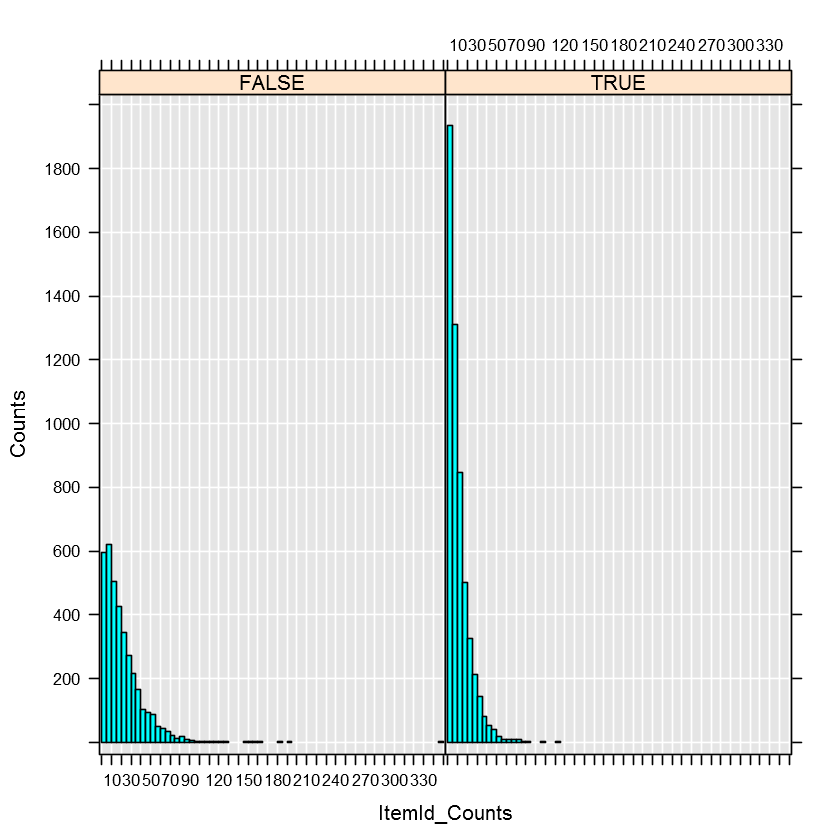

In [29]:
rxHistogram(~ ItemId_Counts | Label, dataset)

The side-by-side histograms in the figure show that the non-churners on the left, the "FALSE", have a different distribution of counts than the churners on the right, the "TRUE".

### <a id="Split">2.6. SPLIT THE DATASET INTO TRAIN AND TEST</a>

To create train and test sets, the data are randomly split by customer into two datasets. The training data customers will be used by the learners to fit models, while the test data customers will be used as a fair measure the performance of the fit models. Because the split is randomized, we first set the random seed used by the randomizer to guarantee we will be able to reproduce our results at a later date.

In [30]:
#-----------------------------------------------------------------------
# 6. Split the dataset into train and test data.
#-----------------------------------------------------------------------
# Set the random seed for reproducibility of randomness.
set.seed(4253, "L'Ecuyer-CMRG")

# Randomly split the data 80-20 between train and test sets.
dataProb <- c(Train = 0.8, Test = 0.2)
dataSplit <-
    rxSplit(dataset,
            splitByFactor = "splitVar",
            transforms = list(splitVar =
                                sample(dataFactor,
                                       size = .rxNumRows,
                                       replace = TRUE,
                                       prob = dataProb)),
            transformObjects =
                list(dataProb = dataProb,
                     dataFactor = factor(names(dataProb),
                                         levels = names(dataProb))),
            outFilesBase = tempfile())

# Name the train and test datasets.
dataTrain <- dataSplit[[1]]
dataTest <- dataSplit[[2]]

Rows Read: 9159, Total Rows Processed: 9159Rows Read: 7309, Total Rows Processed: 7309, Total Chunk Time: 0.055 seconds 
Rows Read: 1850, Total Rows Processed: 1850, Total Chunk Time: 0.038 seconds 
, Total Chunk Time: 0.852 seconds 


We can explore the distribution of "Label" in the train and test sets.

In [31]:
rxSummary(~ Label, dataTrain)$sDataFrame
rxSummary(~ Label, dataTest)$sDataFrame

Rows Read: 7309, Total Rows Processed: 7309, Total Chunk Time: 0.003 seconds 
Computation time: 0.012 seconds.


,Name,Mean,StdDev,Min,Max,ValidObs,MissingObs
1,Label,0.598440279107949,0.490247278956304,0,1,7309,0


Rows Read: 1850, Total Rows Processed: 1850, Total Chunk Time: 0.006 seconds 
Computation time: 0.016 seconds.


,Name,Mean,StdDev,Min,Max,ValidObs,MissingObs
1,Label,0.612972972972973,0.487201614330556,0,1,1850,0


We read from the output that train has 7,309 rows while test has 1,850 rows. Because Label is a boolean, its mean shows the proportion of churners in the data. We see that train contains almost 60% churners and that test contains a bit more than 61% churners, which is a reasonable split.

### <a id="Model">2.7. DEFINE THE MODEL</a>

The model is a formula that describes what column has the label, and what columns are to be used to rxPredict the label. We will use as rxPredictors the feature column names from the dataset, which is all columns except for UserId, Label, and splitVar. Then we create a formula that says that Label is to be rxPredicted by the rxPredictor columns.

In [32]:
#-----------------------------------------------------------------------
# 7. Define the model to be fit.
#-----------------------------------------------------------------------
# The variables in the data.
allVars <- names(dataTrain)

# The other variables are the record's properties.
xVars <- setdiff(allVars, c("UserId", "Label", "splitVar"))

# The model is a formula that says that churners are to be
# identified using the other variables.
(model <- formula(paste("Label ~", paste(xVars, collapse = " + "))))

Label ~ Age + Address + Recency + MeanDaysBetweenActivity + Quantity_StdDev + 
    Quantity_Sum + Value_StdDev + Value_Sum + TransactionId_Counts + 
    ItemId_Counts + Quantity_per_TransactionId + Quantity_per_ItemId + 
    Value_per_TransactionId + Value_per_ItemId

The left-hand side of the formula is the label, while the right-hand side lists the rxPredictors.

### <a id="Fit">2.8. FIT THE MODEL</a>

The model will be fit by learners that can rxPredict class data: rxLogisticRegression, rxFastLinear, rxFastTrees, rxFastForest, and rxNeuralNet. In the next section, each fit will be used to score the test data. The comments in this section give a glimpse of the kind of work done by each learner.

In [33]:
#-----------------------------------------------------------------------
# 8. Fit the model using different learners.
#-----------------------------------------------------------------------
# Fit the model with logistic regression. This finds the variable
# weights that are most useful for rxPredicting churning. The
# rxLogisticRegression learner automatically adjusts the weights to select
# those variables that are most useful for making rxPredictions.
rxLogisticRegressionFit <- rxLogisticRegression(model, data = dataTrain)

Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Beginning read for block: 1
Rows Read: 7309, Read Time: 0.008, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
LBFGS multi-threading will attempt to load dataset into memory. In case of out-of-memory issues, turn off multi-threading by setting trainThreads to 1.
Beginning read for block: 1
Rows Read: 7309, Read Time: 0.009, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning optimization
num vars: 32
improvement criterion: Mean Improvement
L1 regularization selected 26 of 32 weights.
Not training a calibrator because it is not needed.
Elapsed time: 00:00:01.2134274
Elapsed time: 00:00:00.3131805


In [34]:
#-----------------------------------------------------------------------
# Fit the model with linear regression. This finds the variable
# weights that are most useful for rxPredicting churning. The
# rxFastLinear learner automatically adjusts the weights to select
# those variables that are most useful for making rxPredictions.
rxFastLinearFit <- rxFastLinear(model, data = dataTrain)

Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Beginning read for block: 1
Rows Read: 7309, Read Time: 0.022, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 7309, Read Time: 0.014, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 7309, Read Time: 0.011, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Wrote 7309 rows across 2 columns in 00:00:00.0858921
Using 2 threads to train.
Automatically choosing a check frequency of 2.
Auto-tuning parameters: maxIterations = 204.
Auto-tuning parameters: L2 = 2.682699E-05.
Auto-tuning parameters: L1Threshold (L1/L2) = 0.
Using best model from iteration 18.
Not training a calibrator because it is not needed.
Elapsed time: 00:00:00.6221419
Elapsed time: 00:00:00.0475899


In [35]:
#-----------------------------------------------------------------------
# Fit the model with boosted trees. This finds the combinations of
# variables and threshold values that are useful for rxPredicting churning.
# The rxFastTrees learner automatically builds a sequence of trees so that
# trees later in the sequence repair errors made by trees earlier in the
# sequence.
rxFastTreesFit <- rxFastTrees(model, data = dataTrain, randomSeed = 23648)

Not adding a normalizer.
Making per-feature arrays
Changing data from row-wise to column-wise
Beginning read for block: 1
Rows Read: 7309, Read Time: 0.008, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Processed 7309 instances
Binning and forming Feature objects
Reserved memory for tree learner: 424996 bytes
Starting to train ...
Not training a calibrator because it is not needed.
Elapsed time: 00:00:00.6793178


In [36]:
#-----------------------------------------------------------------------
# Fit the model with random forest. This finds the combinations of
# variables and threshold values that are useful for rxPredicting churning.
# The rxFastForest learner automatically builds a set of trees whose
# combined rxPredictions are better than the rxPredictions of any one of the
# trees.
rxFastForestFit <- rxFastForest(model, data = dataTrain, randomSeed = 23648)

Not adding a normalizer.
Making per-feature arrays
Changing data from row-wise to column-wise
Beginning read for block: 1
Rows Read: 7309, Read Time: 0.007, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Processed 7309 instances
Binning and forming Feature objects
Reserved memory for tree learner: 424996 bytes
Starting to train ...
Training calibrator.
Beginning read for block: 1
Rows Read: 7309, Read Time: 0.009, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:00.6574803


In [37]:
#-----------------------------------------------------------------------
# Fit the model with neural net. This finds the variable weights that
# are most useful for rxPredicting churning. Neural net can excel when
# dealing with non-linear relationships between the variables.
rxNeuralNetFit <- rxNeuralNet(model, data = dataTrain)

Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Beginning read for block: 1
Rows Read: 7309, Read Time: 0.009, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 7309, Read Time: 0.007, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Beginning read for block: 1
Rows Read: 7309, Read Time: 0.008, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Wrote 7309 rows across 2 columns in 00:00:00.0486290
Using: SSE Math

***** Net definition *****
  input Data [31];
  hidden H [100] sigmoid { // Depth 1
    from Data all;
  }
  output Result [2] sigmoid { // Depth 0
    from H all;
  }
***** End net definition *****
Input count: 31
Output count: 2
Output Function: Sigmoid
Loss Function: CrossEntropy
PreTrainer: NoPreTrainer
__________________________________________

### <a id="Score">2.9. SCORE THE TEST DATA</a>

Each fit will be used to score the test data.  In order to plot together each fit's performance for convenient side-by-side comparison, we append each rxPrediction column to the test dataset. This will also conveniently include the Label column with the rxPredictions, so that the rxPrediction performance can be computed. When the test data are huge, scoring in this manner may not be possible. In that case, each rxPrediction set will have to be computed separately, and then merged into one data table.

In [38]:
#-----------------------------------------------------------------------
# 9. Score the held-aside test data with the fit models.
#-----------------------------------------------------------------------
# The scores are each test record's probability of being a churner. This
# combines each fit model's rxPredictions and the label into one table
# for side-by-side plotting and comparison.
fitScores <-
    rxPredict(rxLogisticRegressionFit, dataTest, suffix = ".rxLogisticRegression",
              extraVarsToWrite = names(dataTest),
              outData = tempfile(fileext = ".xdf"))
fitScores <-
    rxPredict(rxFastLinearFit, fitScores, suffix = ".rxFastLinear",
              extraVarsToWrite = names(fitScores),
              outData = tempfile(fileext = ".xdf"))
fitScores <-
    rxPredict(rxFastTreesFit, fitScores, suffix = ".rxFastTrees",
              extraVarsToWrite = names(fitScores),
              outData = tempfile(fileext = ".xdf"))
fitScores <-
    rxPredict(rxFastForestFit, fitScores, suffix = ".rxFastForest",
              extraVarsToWrite = names(fitScores),
              outData = tempfile(fileext = ".xdf"))
fitScores <-
    rxPredict(rxNeuralNetFit, fitScores, suffix = ".rxNeuralNet",
              extraVarsToWrite = names(fitScores),
              outData = tempfile(fileext = ".xdf"))

Beginning read for block: 1
Rows Read: 1850, Read Time: 0.017, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:00.3163578
Finished writing 1850 rows.
Writing completed.
Beginning read for block: 1
Rows Read: 1850, Read Time: 0.011, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:00.2339721
Finished writing 1850 rows.
Writing completed.
Beginning read for block: 1
Rows Read: 1850, Read Time: 0.015, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:00.2864641
Finished writing 1850 rows.
Writing completed.
Beginning read for block: 1
Rows Read: 1850, Read Time: 0.01, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:00.2866353
Finished writing 1850 rows.
Writing completed.
Beginning read for block: 1
Rows Read: 1850, Read Time: 0.014, Tr

We see from the output above that the number of rows in the results is the same as the number of rows in the test data.

### <a id="Compare">2.10. COMPARE THE FIT MODEL PERFORMANCE</a>

For each fit model, its rxPredictions and the Label are used to compute an ROC curve for that fit. The curves will then be plotted side-by-side in a graph.

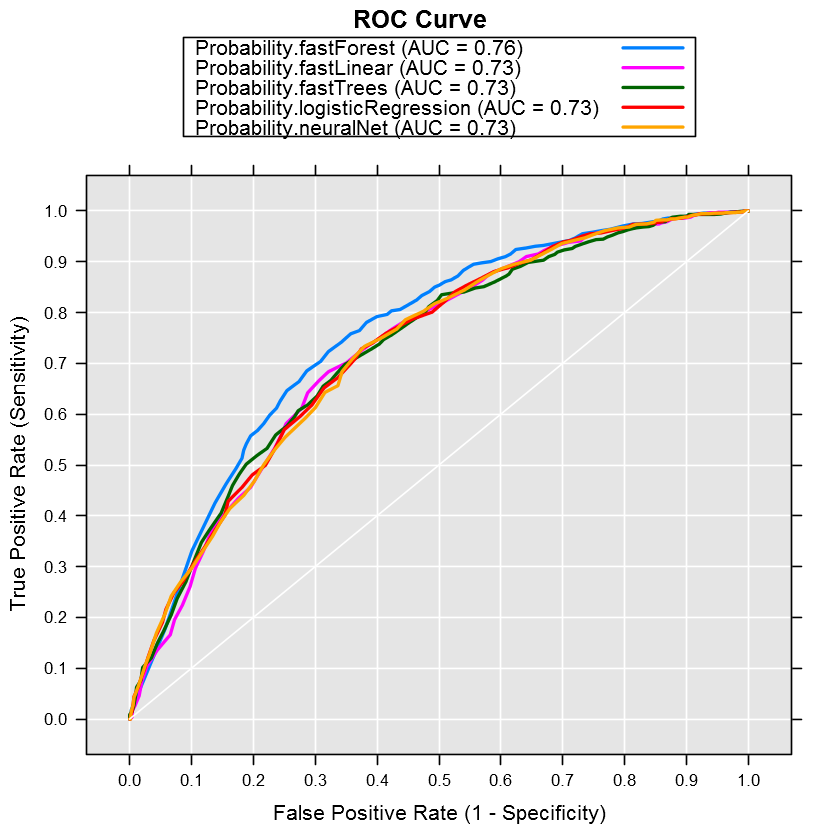

In [39]:
#-----------------------------------------------------------------------
# 10. Compare the performance of fit models.
#-----------------------------------------------------------------------
# Compute ROC curves for the fit models.
fitRoc <-
    rxRoc("Label",
          paste("Probability",
                 c("rxLogisticRegression", "rxFastLinear", "rxFastTrees",
                   "rxFastForest", "rxNeuralNet"),
                 sep = "."),
          fitScores)

# Plot the ROC curves and report their AUCs.
plot(fitRoc)

The fit models are then used to compute the fit model AUCs, and these are used to select the best model.

In [40]:
# Create a named list of the fit models.
fitList <-
    list(rxLogisticRegression = rxLogisticRegressionFit,
         rxFastLinear = rxFastLinearFit,
         rxFastTrees = rxFastTreesFit,
         rxFastForest = rxFastForestFit,
         rxNeuralNet = rxNeuralNetFit)

# Compute the AUCs of the fit models.
fitAuc <- rxAuc(fitRoc)
names(fitAuc) <- substring(names(fitAuc), nchar("Probability.") + 1)

# Find the name of the fit with the largest AUC.
bestFitName <- names(which.max(fitAuc))

# Select the fit model with the largest AUC.
bestFit <- fitList[[bestFitName]]

# Report the fit AUCs.
cat("Fit model AUCs:\n")
print(fitAuc, digits = 2)

# Report the best fit.
cat(paste0("Best fit model with ", bestFitName,
           ", AUC = ", signif(fitAuc[[bestFitName]], digits = 2),
           ".\n"))

Fit model AUCs:
        rxFastForest         rxFastLinear          rxFastTrees rxLogisticRegression 
              0.76               0.73               0.73               0.73 
         rxNeuralNet 
              0.73 
Best fit model with rxFastForest, AUC = 0.76.


In the end, the best fit model is stored in variable bestFit.

## <a id="Next">3. WHAT'S NEXT?</a>

In the Microsoft ML samples directory, the script Churn.R contains all the R code used in this tutorial. It also contains other scripts formatted to follow the steps used for retail churn. Try them out interactively, and learn about other Microsoft ML capabilities.